<a href="https://colab.research.google.com/github/Shashank-177/Using-RL-to-predict-stocks-behavior-/blob/main/Stock_market_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install stable_baselines3

In [11]:
!pip install 'shimmy>=0.2.1

/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import gymnasium as gym
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from gymnasium import spaces
import matplotlib.pyplot as plt

class StockTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=10000):
        super(StockTradingEnv, self).__init__()

        # Stock data
        self.df = df
        self.current_step = 0

        # Portfolio variables
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.shares_held = 0
        self.portfolio_value = self.initial_balance

        # Action space: Buy, Hold, Sell
        self.action_space = spaces.Discrete(3)
        self.action_val = None

        # Observation space: stock price, cash, stock holdings
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)

        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        self.portfolio_value = self.initial_balance
        return self._get_observation(), {}

    def _get_observation(self):
        current_price = self.df.iloc[self.current_step]['Close']
        return np.array([current_price, self.balance, self.shares_held])

    def step(self,action):
        current_price = self.df.iloc[self.current_step]['Close']
        reward = 0
        # action_ = []
        # portfolio_value_ = []
        # current_step_ = []

        # Execute action
        if action == 0:  # Buy
            if self.balance > current_price:
                self.shares_held += 1
                self.balance -= current_price
                self.action_val = 0

        elif action == 2:  # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price
                self.action_val = 2
        else:
            self.action_val = 1

        # Calculate portfolio value
        self.portfolio_value = self.balance + self.shares_held * current_price

        # Reward
        reward = (self.portfolio_value - self.initial_balance)*2
        # action_.append(action)
        # portfolio_value_.append(self.portfolio_value)

        # Update current step
        self.current_step += 1
        # current_step_.append(self.current_step)

        # Check if episode is done
        done = self.current_step >= len(self.df) - 1  # End of data
        truncated = False  # No truncation here
        info = {}
        return self._get_observation(), reward, done, truncated,  info   #action, portfolio_value_

    def render(self, action = None, mode='human'):
      current_price = self.df.iloc[self.current_step]['Close']
      if isinstance(action, np.ndarray):
        action = action[0]  # Extract the value from the array
      action_str = {0: "Buy", 1: "Hold", 2: "Sell"}.get(action, "None")
      print(f'Step: {self.current_step}, Price: {current_price}, Shares Held: {self.shares_held}, Balance: {self.balance}, Portfolio Value: {self.portfolio_value}, Action: {action_str}')



Tesla stock prediction

In [14]:
file1 = "/content/drive/MyDrive/TSLA.csv"
df = pd.read_csv(file1)
df.head()
split_index = int(len(df) * 0.85)
train_df = df[:split_index]
test_df = df[split_index:]

In [15]:
print(train_df)

            Date        Open        High         Low       Close   Adj Close  \
0     2010-06-29    3.800000    5.000000    3.508000    4.778000    4.778000   
1     2010-06-30    5.158000    6.084000    4.660000    4.766000    4.766000   
2     2010-07-01    5.000000    5.184000    4.054000    4.392000    4.392000   
3     2010-07-02    4.600000    4.620000    3.742000    3.840000    3.840000   
4     2010-07-06    4.000000    4.000000    3.166000    3.222000    3.222000   
...          ...         ...         ...         ...         ...         ...   
2507  2020-06-15  183.557999  199.768005  181.699997  198.179993  198.179993   
2508  2020-06-16  202.369995  202.576004  192.477997  196.425995  196.425995   
2509  2020-06-17  197.542007  201.000000  196.514008  198.358002  198.358002   
2510  2020-06-18  200.600006  203.839996  198.893997  200.792007  200.792007   
2511  2020-06-19  202.556000  203.194000  198.268005  200.179993  200.179993   

        Volume  
0     93831500  
1    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Train the RL model in the environment

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


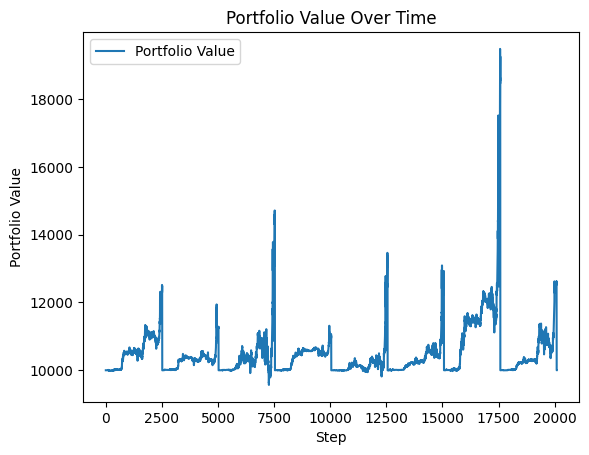

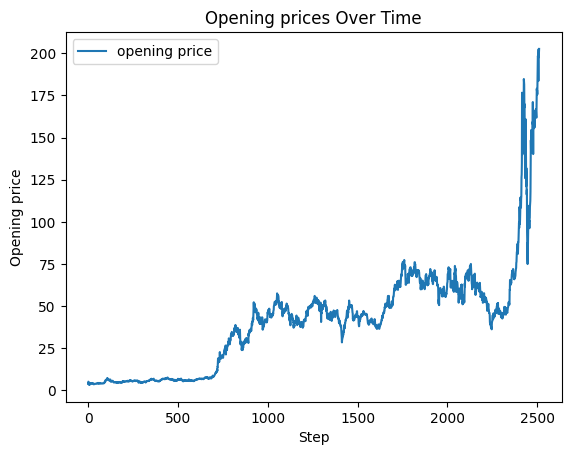

In [16]:
# Instantiate environment
env = StockTradingEnv(train_df)

# Total timesteps for training
total_timesteps = 20096

# Instantiate model
model = PPO("MlpPolicy", env, verbose=1)

portfolio_values = []
action_ = []

# Train the model and record portfolio values after each step
obs, _ = env.reset()  # Reset environment and unpack the observation
for i in range(1,total_timesteps):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    portfolio_values.append(env.portfolio_value)  # Append the portfolio value
    action_.append(env.action_val)
    if done or truncated:
        obs, _ = env.reset()

# Plot the portfolio value over time
plt.figure(1)
plt.plot(portfolio_values, label="Portfolio Value")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.legend()

plt.figure(2)
plt.plot(train_df['Open'],label ="opening price")
plt.xlabel("Step")
plt.ylabel("Opening price")
plt.title("Opening prices Over Time")
plt.legend()


In [17]:
!pip install mpld3

In [ ]:
!pip install emoji

length of actions taken: 20095
index from where to start the last round: 2512


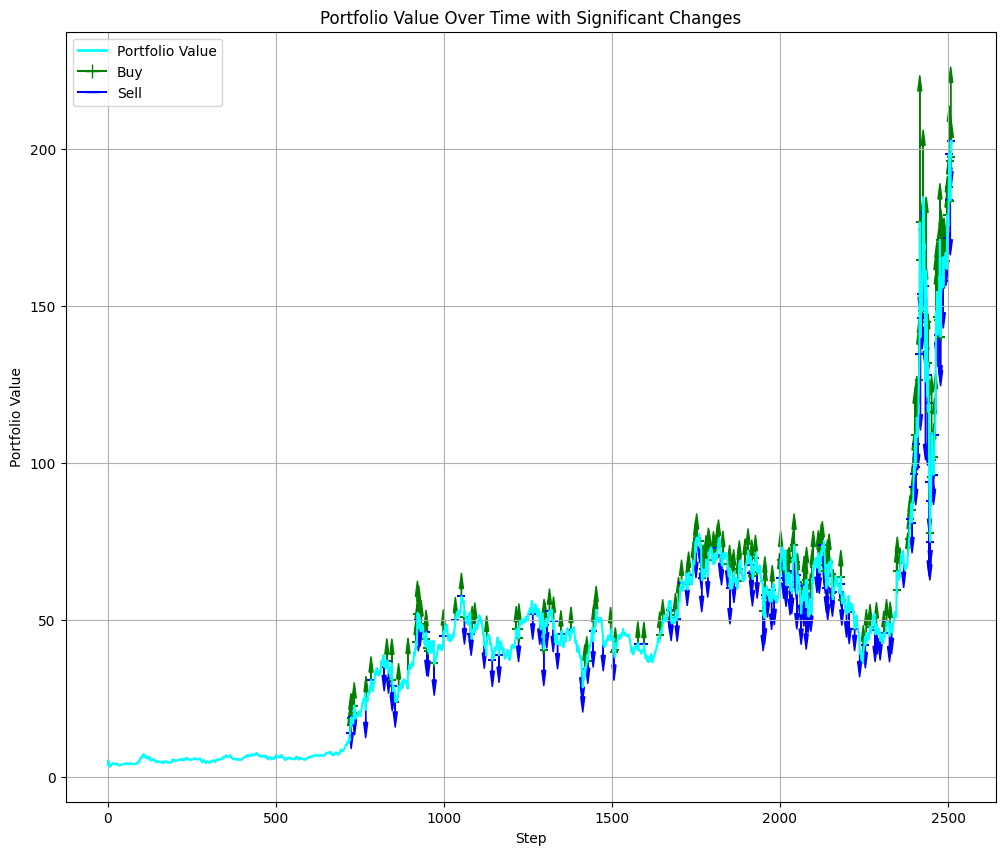

In [38]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib.lines import Line2D

# Calculate the sign, length, and index of significant changes
sign = []
length = []
index = []
for i in range(1, len(train_df["Open"])):
    diff = train_df["Open"][i] - train_df["Open"][i - 1]
    if diff > 0:
        sign.append(1)
    else:
        sign.append(-1)
    if abs(diff) > 2:  # Threshold for significant change
        length.append(diff)
        index.append(i)

# Ensure index and length alignment
assert len(length) == len(index)
print("length of actions taken:",len(action_))
print("index from where to start the last round:",len(action_[17583:]))
# Plot the portfolio value
plt.figure(figsize=(12, 10))
steps = np.arange(len(train_df['Open']))
plt.plot(steps, train_df['Open'], label="Portfolio Value", color='cyan')

# Add arrows for significant changes
for i in range(len(index)):
    step = index[i]
    direction = length[i]
    if sign[step - 1] == 1:  # Green arrow for upward trend
        plt.arrow(step, train_df["Open"][step], 0, direction, color='green', head_width=12,head_length = 5)
    else:  # Blue arrow for downward trend
        plt.arrow(step, train_df["Open"][step], 0, direction, color='blue', head_width=12,head_length = 5)
    if action_[17583:][i] == 0:
      plt.scatter(step, train_df["Open"][step],marker = '+',color = 'green')
    elif action_[17583:][i] == 2:
      plt.scatter(step, train_df["Open"][step],marker = '_',color = 'blue')

# Add labels and legend
legend_handles = [
    Line2D([0], [0], color="cyan", lw=2, label="Portfolio Value"),  # Line
    Line2D([0], [0], marker="+", color="green",  markersize=10, label="Buy"),  # Buy
    Line2D([0], [0], marker="_", color="blue", markerfacecolor="red", markersize=10, label="Sell"),  # Sell
]
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time with Significant Changes")
plt.legend(handles=legend_handles)
plt.grid(True)
plt.show()


Test the model in the test cases


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Step: 1, Price: 200.356003, Shares Held: 0, Balance: 10000, Portfolio Value: 10000.0, Action: None
Step: 2, Price: 192.169998, Shares Held: 0, Balance: 10000, Portfolio Value: 10000.0, Action: None
Step: 3, Price: 197.195999, Shares Held: 0, Balance: 10000, Portfolio Value: 10000.0, Action: None
Step: 4, Price: 191.947998, Shares Held: 0, Balance: 10000, Portfolio Value: 10000.0, Action: None
Step: 5, Price: 201.869995, Shares Held: 1, Balance: 9808.052002, Portfolio Value: 10000.0, Action: None
Step: 6, Price: 215.962006, Shares Held: 1, Balance: 9808.052002, Portfolio Value: 10009.921997, Action: None
Step: 7, Price: 223.925995, Shares Held: 2, Balance: 9592.089996, Portfolio Value: 10024.014008, Action: None
Step: 8, Price: 241.731995, Shares Held: 2, Balance: 9592.089996, Portfolio Value: 10039.941986, Action: None
Step: 9, Price: 274.31601, Shares Held: 2, Balance: 9592.089996, Portfolio Value: 10075.553986, Action: None
Step: 10, Price: 277.971985, Shares Held: 3, Balance: 9317.7

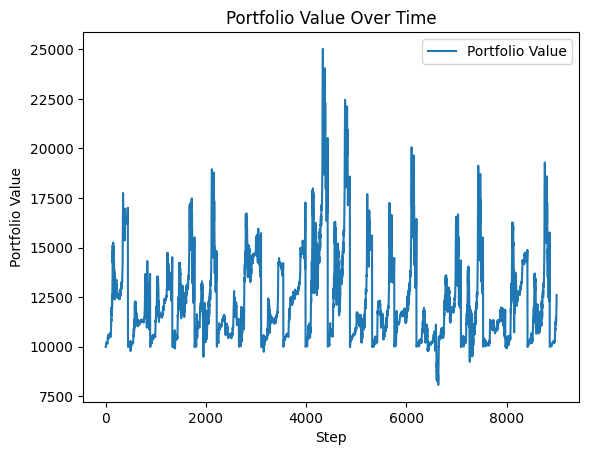

In [ ]:
# Test the trained model
env = StockTradingEnv(test_df)

obs, _ = env.reset()  # Unpack the tuple from env.reset()

for i in range(len(test_df)):
    action, _ = model.predict(obs)  # Only pass 'obs' to the model
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        break
total_timesteps2 = 9000

# Instantiate model
model = PPO("MlpPolicy", env, verbose=1)

portfolio_values = []
# Print final portfolio value
obs, _ = env.reset()  # Reset environment and unpack the observation
for i in range(total_timesteps2):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    portfolio_values.append(env.portfolio_value)  # Append the portfolio value

    if done or truncated:
        obs, _ = env.reset()  # Reset environment if done

# Plot the portfolio value over time
plt.plot(portfolio_values, label="Portfolio Value")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.show()

Google stock prediction



In [ ]:
file1 = "/content/drive/MyDrive/GOOGL.csv"
df = pd.read_csv(file1)
df.head()
split_index = int(len(df) * 0.85)
train_df = df[:split_index]
test_df = df[split_index:]

In [ ]:
print(train_df)

            Date         Open         High          Low        Close  \
0     2004-08-19    50.050049    52.082081    48.028027    50.220219   
1     2004-08-20    50.555557    54.594597    50.300301    54.209209   
2     2004-08-23    55.430431    56.796799    54.579578    54.754753   
3     2004-08-24    55.675674    55.855858    51.836838    52.487488   
4     2004-08-25    52.532532    54.054054    51.991993    53.053055   
...          ...          ...          ...          ...          ...   
3761  2019-07-30  1227.000000  1236.910034  1225.319946  1228.000000   
3762  2019-07-31  1224.869995  1234.910034  1208.180054  1218.199951   
3763  2019-08-01  1217.630005  1236.300049  1207.000000  1211.780029   
3764  2019-08-02  1203.000000  1209.500000  1190.000000  1196.319946   
3765  2019-08-05  1172.969971  1176.880005  1142.750000  1154.750000   

        Adj Close    Volume  
0       50.220219  44659096  
1       54.209209  22834343  
2       54.754753  18256126  
3       52.4874

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


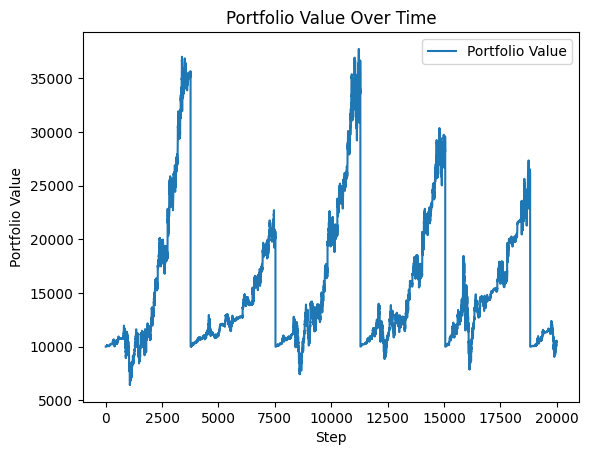

In [ ]:
env = StockTradingEnv(train_df)

# Total timesteps for training
total_timesteps = 20000

# Instantiate model
model = PPO("MlpPolicy", env, verbose=1)

portfolio_values = []

# Train the model and record portfolio values after each step
obs, _ = env.reset()  # Reset environment and unpack the observation
for i in range(total_timesteps):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    portfolio_values.append(env.portfolio_value)  # Append the portfolio value

    if done or truncated:
        obs, _ = env.reset()  # Reset environment if done

# Plot the portfolio value over time
plt.plot(portfolio_values, label="Portfolio Value")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.show()

Step: 1, Price: 1175.910034, Shares Held: 1, Balance: 8828.920044, Portfolio Value: 10000.0, Action: None
Step: 2, Price: 1206.189941, Shares Held: 0, Balance: 10004.830078, Portfolio Value: 10004.830078, Action: None
Step: 3, Price: 1188.900024, Shares Held: 0, Balance: 10004.830078, Portfolio Value: 10004.830078, Action: None
Step: 4, Price: 1174.5, Shares Held: 1, Balance: 8815.930054, Portfolio Value: 10004.830078, Action: None
Step: 5, Price: 1196.72998, Shares Held: 0, Balance: 9990.430054, Portfolio Value: 9990.430054, Action: None
Step: 6, Price: 1164.25, Shares Held: 1, Balance: 8793.700074, Portfolio Value: 9990.430054, Action: None
Step: 7, Price: 1169.319946, Shares Held: 1, Balance: 8793.700074, Portfolio Value: 9957.950074, Action: None
Step: 8, Price: 1179.209961, Shares Held: 1, Balance: 8793.700074, Portfolio Value: 9963.02002, Action: None
Step: 9, Price: 1200.439941, Shares Held: 1, Balance: 8793.700074, Portfolio Value: 9972.910035, Action: None
Step: 10, Price: 118

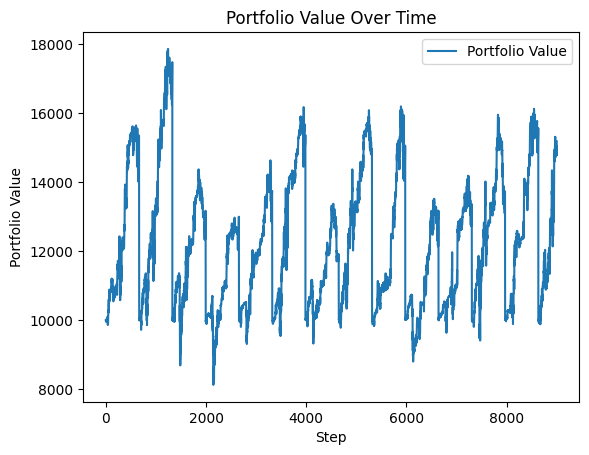

In [ ]:
env = StockTradingEnv(test_df)

obs, _ = env.reset()  # Unpack the tuple from env.reset()

for i in range(len(test_df)):
    action, _ = model.predict(obs)  # Only pass 'obs' to the model
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        break
total_timesteps2 = 9000

# Instantiate model
model = PPO("MlpPolicy", env, verbose=1)

portfolio_values = []
# Print final portfolio value
obs, _ = env.reset()  # Reset environment and unpack the observation
for i in range(total_timesteps2):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    portfolio_values.append(env.portfolio_value)  # Append the portfolio value

    if done or truncated:
        obs, _ = env.reset()  # Reset environment if done

# Plot the portfolio value over time
plt.plot(portfolio_values, label="Portfolio Value")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.show()

Amazon stocks

In [ ]:
file1 = "/content/drive/MyDrive/AMZN.csv"
df = pd.read_csv(file1)
df.head()
split_index = int(len(df) * 0.85)
train_df = df[:split_index]
test_df = df[split_index:]

In [ ]:
print(train_df)

            Date         Open         High          Low        Close  \
0     1997-05-15     2.437500     2.500000     1.927083     1.958333   
1     1997-05-16     1.968750     1.979167     1.708333     1.729167   
2     1997-05-19     1.760417     1.770833     1.625000     1.708333   
3     1997-05-20     1.729167     1.750000     1.635417     1.635417   
4     1997-05-21     1.635417     1.645833     1.375000     1.427083   
...          ...          ...          ...          ...          ...   
5313  2018-06-26  1672.369995  1701.569946  1663.339966  1691.089966   
5314  2018-06-27  1708.109985  1711.949951  1660.000000  1660.510010   
5315  2018-06-28  1672.540039  1705.500000  1661.170044  1701.449951   
5316  2018-06-29  1717.000000  1723.410034  1694.319946  1699.800049   
5317  2018-07-02  1682.699951  1713.890015  1678.060059  1713.780029   

        Adj Close    Volume  
0        1.958333  72156000  
1        1.729167  14700000  
2        1.708333   6106800  
3        1.6354

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


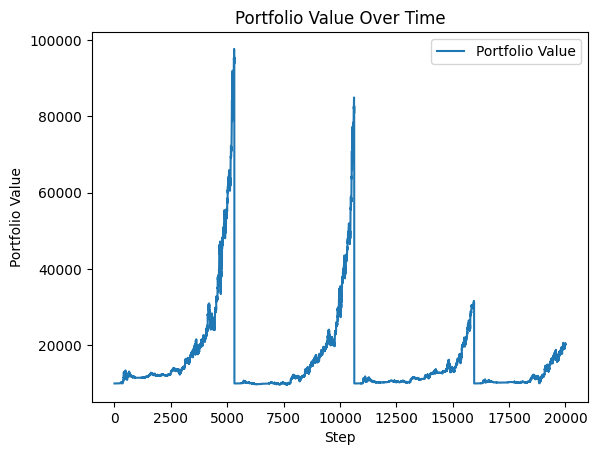

In [ ]:
env = StockTradingEnv(train_df)

# Total timesteps for training
total_timesteps = 20000

# Instantiate model
model = PPO("MlpPolicy", env, verbose=1)

portfolio_values = []

# Train the model and record portfolio values after each step
obs, _ = env.reset()  # Reset environment and unpack the observation
for i in range(total_timesteps):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    portfolio_values.append(env.portfolio_value)  # Append the portfolio value

    if done or truncated:
        obs, _ = env.reset()  # Reset environment if done

# Plot the portfolio value over time
plt.plot(portfolio_values, label="Portfolio Value")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.show()

Step: 1, Price: 1699.72998, Shares Held: 1, Balance: 8306.040039, Portfolio Value: 10000.0, Action: None
Step: 2, Price: 1710.630005, Shares Held: 2, Balance: 6606.3100589999995, Portfolio Value: 10005.770019, Action: None
Step: 3, Price: 1739.02002, Shares Held: 2, Balance: 6606.3100589999995, Portfolio Value: 10027.570069, Action: None
Step: 4, Price: 1743.069946, Shares Held: 3, Balance: 4867.2900389999995, Portfolio Value: 10084.350099, Action: None
Step: 5, Price: 1755.0, Shares Held: 2, Balance: 6610.359984999999, Portfolio Value: 10096.499876999998, Action: None
Step: 6, Price: 1796.619995, Shares Held: 1, Balance: 8365.359985, Portfolio Value: 10120.359985, Action: None
Step: 7, Price: 1813.030029, Shares Held: 1, Balance: 8365.359985, Portfolio Value: 10161.97998, Action: None
Step: 8, Price: 1822.48999, Shares Held: 0, Balance: 10178.390013999999, Portfolio Value: 10178.390013999999, Action: None
Step: 9, Price: 1843.930054, Shares Held: 0, Balance: 10178.390013999999, Portfo

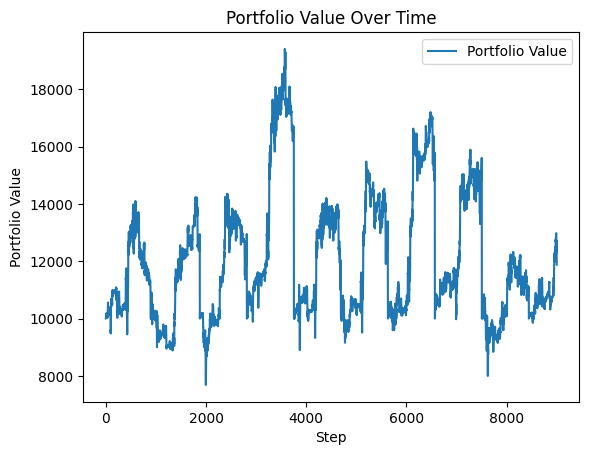

In [ ]:
env = StockTradingEnv(test_df)

obs, _ = env.reset()  # Unpack the tuple from env.reset()

for i in range(len(test_df)):
    action, _ = model.predict(obs)  # Only pass 'obs' to the model
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        break
total_timesteps2 = 9000

# Instantiate model
model = PPO("MlpPolicy", env, verbose=1)

portfolio_values = []
# Print final portfolio value
obs, _ = env.reset()  # Reset environment and unpack the observation
for i in range(total_timesteps2):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    portfolio_values.append(env.portfolio_value)  # Append the portfolio value

    if done or truncated:
        obs, _ = env.reset()  # Reset environment if done

# Plot the portfolio value over time
plt.plot(portfolio_values, label="Portfolio Value")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.show()